In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## A

In [8]:
point_cloud_velo = 'kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data/0000000003.bin'

In [9]:
data = np.fromfile(point_cloud_velo, dtype=np.float32)
data = data.reshape((-1, 4))
point_cloud = data[:, :3]
np_pcd = np.asarray(point_cloud)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np_pcd)
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


## B,C

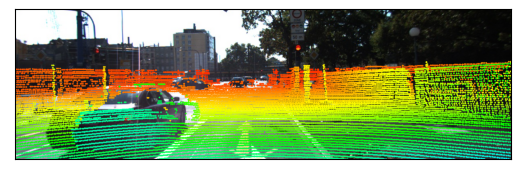

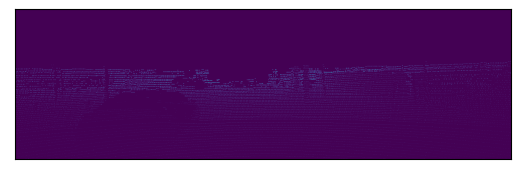

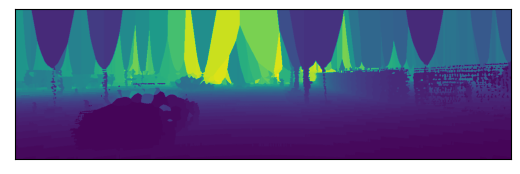

In [4]:
import numpy as np
import os

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cv2

P_velo2cam_ref = np.asarray([[7.755449e-03, -9.999694e-01, -1.014303e-03, -7.275538e-03],
                             [2.294056e-03, 1.032122e-03, -9.999968e-01, -6.324057e-02],
                             [9.999673e-01, 7.753097e-03, 2.301990e-03, -2.670414e-01], [0, 0, 0, 1]])
R_ref2rect = np.asarray(
    [[9.999478e-01, 9.791707e-03, -2.925305e-03, 0], [-9.806939e-03, 9.999382e-01, -5.238719e-03, 0],
     [2.873828e-03, 5.267134e-03, 9.999820e-01, 0], [0, 0, 0, 0]])
P_rect2cam2 = np.asarray(
    [[7.183351e+02, 0.000000e+00, 6.003891e+02, 0.000000e+00], [0.000000e+00, 7.183351e+02, 1.815122e+02, 0.000000e+00],
     [0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00]])
proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref


def project_to_image(points, proj_mat):
    num_pts = points.shape[1]

    # Change to homogenous coordinate
    points = np.vstack((points, np.ones((1, num_pts))))
    points = proj_mat @ points
    points[:2, :] /= points[2, :]
    return points[:2, :]


def load_velo_scan(velo_filename):
    data = np.fromfile(velo_filename, dtype=np.float32)
    data = data.reshape((-1, 4))
    return data


def render_lidar_on_image(pts_velo, img, proj_mat, img_width, img_height):
    # projection matrix (project from velo2cam2)
    proj_velo2cam2 = proj_mat

    # apply projection
    pts_2d = project_to_image(pts_velo.transpose(), proj_velo2cam2)

    # Filter lidar points to be within image FOV
    inds = np.where((pts_2d[0, :] < img_width) & (pts_2d[0, :] >= 0) &
                    (pts_2d[1, :] < img_height) & (pts_2d[1, :] >= 0) &
                    (point_cloud_velo[:, 0] > 0)
                    )[0]

    # Filter out pixels points
    imgfov_pc_pixel = pts_2d[:, inds]

    # Retrieve depth from lidar
    imgfov_point_cloud_velo = pts_velo[inds, :]
    imgfov_point_cloud_velo = np.hstack((imgfov_point_cloud_velo, np.ones((imgfov_point_cloud_velo.shape[0], 1))))
    imgfov_pc_cam2 = proj_velo2cam2 @ imgfov_point_cloud_velo.transpose()

    cmap = plt.cm.get_cmap('hsv', 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    dept_image = np.zeros((img_height, img_width))
    depth_list = []
    depth_y = []
    depth_x = []

    for i in range(imgfov_pc_pixel.shape[1]):
        depth = imgfov_pc_cam2[2, i]
        color = cmap[int(640.0 / depth), :]

        depth_list.append(depth)
        depth_y.append(int(np.round(imgfov_pc_pixel[0, i])) - 1)
        depth_x.append(int(np.round(imgfov_pc_pixel[1, i])) - 1)

        dept_image[int(np.round(imgfov_pc_pixel[1, i])) - 1,
                   int(np.round(imgfov_pc_pixel[0, i])) - 1] = depth
        cv2.circle(img, (int(np.round(imgfov_pc_pixel[0, i])),
                         int(np.round(imgfov_pc_pixel[1, i]))),
                   2, color=tuple(color), thickness=-1)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.show()

    plt.imshow(dept_image)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    return img, dept_image, depth_list, depth_y, depth_x


if __name__ == '__main__':
    # Load image, calibration file, label bbox
    rgb = cv2.cvtColor(
        cv2.imread(os.path.join('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_03/data/0000000003.jpg')),
        cv2.COLOR_BGR2RGB)
    img_height, img_width, img_channel = rgb.shape

    # Load Lidar PC
    point_cloud_velo = load_velo_scan('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data/0000000003.bin')[
              :, :3]

    _, depth, depth_list, depth_y, depth_x = render_lidar_on_image(point_cloud_velo, rgb, proj_mat, img_width, img_height)

    X, Y = np.meshgrid(np.arange(0, img_width, 1), np.arange(0, img_height, 1))

    int_depth = griddata((depth_x, depth_y), np.array(depth_list, dtype=int), (Y, X), method='nearest')
    plt.imshow(int_depth)
    plt.yticks([])
    plt.xticks([])
    plt.show()
pass


## D

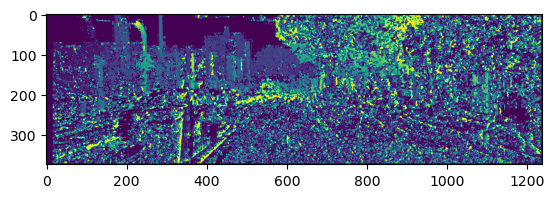

In [5]:
# read left and right images
right_gray = cv2.imread('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_01/data/0000000000.jpg',0)
left_gray = cv2.imread('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_00/data/0000000001.jpg',0)


# creates StereoBm object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
# computes disparity
disparity = stereo.compute(left_gray, right_gray)

plt.imshow(disparity)
plt.show()

## H

In [16]:
def img_to_pointcld(img, depth, K, Rt):
    rgb = o3d.geometry.Image(img)
    depth = o3d.geometry.Image(depth)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, depth_scale=0.4, depth_trunc=50.0,
                                                              convert_rgb_to_intensity=False)
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(int(cx * 2), int(cy * 2), fx, fy, cx, cy)
    pc = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic, Rt)
    o3d.visualization.draw_geometries([pc])




k = np.array([[9.607501e+02, 0.000000e+00, 6.944288e+02], [0.000000e+00, 9.570051e+02, 2.363374e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
rgb_image = cv2.cvtColor(
    cv2.imread(os.path.join('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_02/data/0000000002.jpg')),
    cv2.COLOR_BGR2RGB)

int_depth = np.array(int_depth, dtype='uint8')
img_to_pointcld(rgb_image, int_depth, k, P_velo2cam_ref)